<h1> Multiple Regression <h1>
<blockquote>Now that we have proved that individual stock sentiment does indeed affect their respective returns, albeit not dramatically, we will analyse if sentiment from multiple stocks that are part of the same index can influence its rates of return<blockquote>

In [14]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
path = "F:\Twitter\Tdata\Dataset.xlsx"
df = pd.read_excel (path, sheet_name='Nasdaq_MR')
#df = df2[['S/PLOG','Randament 10 zile']].dropna()
#df = df.dropna()
x1 = df[['S/PALOG','S/PTLOG','S/PNLOG','Const']]

y = df[['Ret 5 days', 'Date']]
x = np.array(df[['S/PALOG','S/PTLOG','S/PNLOG']])
print(y)

     Ret 5 days       Date
0      0.128047 2019-12-22
1      0.428002 2019-12-23
2      1.379618 2019-12-25
3      0.372182 2019-12-26
4      1.402634 2019-12-28
..          ...        ...
231    2.959770 2020-11-19
232    2.677555 2020-11-22
233    2.644561 2020-11-23
234    2.108163 2020-11-24
235    1.403672 2020-11-26

[236 rows x 2 columns]


<h2> Now we shall create a multiple regression linear model using a 80/20 ration between the training data set and the test data set. Of course, the model will be tested in regards to its residual normality, heteroskedasticity and autocorellation in order to figure out if it's a good fit for the given data. <h2>

In [15]:
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
X_train, X_test, y_train, y_test = train_test_split(x1,y, test_size=0.2, random_state=42, shuffle = True)
print(y_test.size)
model1 = sm.OLS(y_train['Ret 5 days'], X_train).fit(cov_type='HAC', cov_kwds={'maxlags':1})
predictions = model1.predict(X_test)
'''print("Breusch-Godfrey Test for residual autocorrelations ",sm.stats.diagnostic.acorr_breusch_godfrey(model1))
print("Breusch-Pagan Test for residual heteroskedasticity ",sm.stats.diagnostic.het_breuschpagan(model1.resid, X_train, robust=True))
print("White test for residual heteroskedasticity ",sm.stats.diagnostic.het_white(model1.resid, X_train))'''
#print("Anderson-Darling Test for testing residual normality",sm.stats.diagnostic.normal_ad(model1.resid))
#figs = sm.qqplot(model1.resid, stats.t, fit = True, line = '45')
plt.show()
print(model1.summary())
print(predictions)

96
                            OLS Regression Results                            
Dep. Variable:             Ret 5 days   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     10.97
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           1.17e-06
Time:                        16:56:16   Log-Likelihood:                -513.06
No. Observations:                 188   AIC:                             1034.
Df Residuals:                     184   BIC:                             1047.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PALOG        0.2109      0.088      2.394      

<h2> Having seen that the model is indeed statistically valid, we shall plot the predicted values vs the empirical ones in order to showcase its accuracy. <h2>

In [17]:
def accuracy (df):

    MAPE = (df['Ret 5 days']- df.Predictions)/df['Ret 5 days']
    MAPE = MAPE.abs()
    print(" MAPE value:", (1/len(MAPE.index) *MAPE.sum()))

    MAE = df['Ret 5 days']- df.Predictions 
    MAE = MAE.abs()

    print(" MAE value:", (1/len(MAE.index)* MAE.sum()))

    RootMeanSquare=  df.Predictions - df['Ret 5 days']
    RootMeanSquare = RootMeanSquare**2
    print('RMSE value:',math.sqrt(RootMeanSquare.mean())) 


 MAPE value: 1.2588326789375242
 MAE value: 2.4901522672746697
RMSE value: 3.4986331837287077


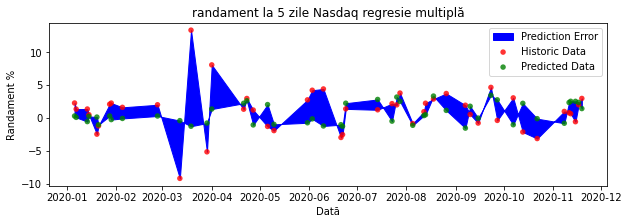

In [18]:
import math
preddb = y_test.merge(predictions.rename('Predictions'), left_index=True, right_index=True)
preddb.sort_index(inplace=True)
accuracy(preddb)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#ax.scatter(preddb['Dată Bursă'],preddb.Error,marker='o', c = 'blue', edgecolors='none', s=30, label='Eroare')
ax.fill_between(preddb['Date'],preddb['Ret 5 days'], preddb.Predictions, color ='b', label = 'Prediction Error')    
ax.scatter(preddb['Date'], preddb['Ret 5 days'], alpha=0.8, c='red', edgecolors='none', s=30, label='Historic Data')
ax.scatter(preddb['Date'], preddb.Predictions, alpha=0.8, c='green', edgecolors='none', s=30, label='Predicted Data')

#plt.plot(preddb['Dată Bursă'],preddb.Error, '-o',zorder=2)
plt.title("Nasdaq's 5 day return prediction")
plt.xlabel('Date')
plt.ylabel('Return %')
plt.legend(loc=1)
plt.show()

<h2>Lastly the 95% confidence interval will be shown in order to observe the outlying returns which the model couldn't have predicted and the residuals plot which shows whether the residuals are distributed randomly or not<h2>

In [19]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    get a prediction interval for a linear regression.

    INPUTS:

    - Single prediction,

    - y_test

    - All test set predicitions,

    - Prediction interval threshold (default = .95)

    OUTPUT:

    - Prediction interval for single prediction
    '''

    #get standard deviation of y_test

    sum_errs = np.sum((y_test - test_predictions)**2)

    stdev = np.sqrt(1/(len(y_test)-2)* sum_errs)

    #get interval from standard deviation

    one_minus_pi = 1 - pi

    ppf_lookup = 1 - (one_minus_pi/2)

    z_score = stats.norm.ppf(ppf_lookup)

    interval = z_score * stdev

    #generate prediction interval lower and upper bound

    lower, upper = prediction - interval, prediction + interval

    return lower, prediction, upper

def Confidence_Interval(y_pred,Original, date):

    lower_vet = []

    upper_vet = []

    for i in y_pred:

            lower, predicition, upper = get_prediction_interval(i, Original, y_pred)

            lower_vet.append(lower)

            upper_vet.append(upper)


    plt.fill_between(date,upper_vet, lower_vet, color ='b', label = 'Confidence Interval 95%')

    plt.plot(date,Original,color='orange', label = 'Historical Values')
    plt.plot(date,y_pred,color='black', label = 'Linear Regression')
    print(y_pred.size)


    plt.xlabel('Date')
    plt.ylabel('Return %')
    plt.title("Prediction of Nasdaq's 5 day returns")
    plt.legend()
    plt.rcParams["figure.figsize"] = (10,3)
    #plt.ylim(-50,50)
    plt.show()

48


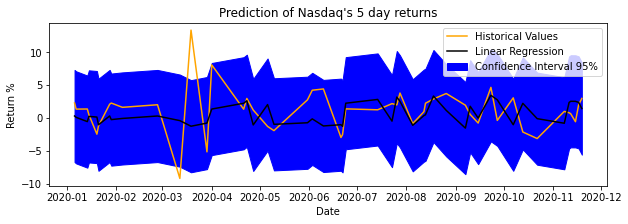

In [20]:
#print(df_fin.iloc[188:,0])
Confidence_Interval(preddb.Predictions,preddb['Ret 5 days'], preddb['Date'])
